# Predicting Hotel Cancellations

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

March 2022




## Initial Setup

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import statsmodels as sm
from math import ceil
from datetime import timedelta
import os

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

#import graphviz

import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, f_regression


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import f1_score

from sklearn.neural_network import MLPClassifier

from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

In [3]:
## Note versions used

print('Pandas version ',pd.__version__)
print('Numpy version ',np.__version__)
print('Scipy version ',sp.__version__)
print('Seaborn version ',sns.__version__)


Pandas version  1.4.1
Numpy version  1.22.2
Scipy version  1.8.0
Seaborn version  0.11.2


In [4]:
COLORS = ['#22446d', '#446f8b', '#689ea6', '#94cdbc', '#e6f9af', '#f5b68e', '#eb756f', '#cb3553', '#93003a']

CAT_COLORS = ['#22446D', '#6ABB5D', '#F3E97B', '#FC9E4F', '#AB2346']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = COLORS.copy()

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
CAT_PALETTE = sns.color_palette(CAT_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = False
RANDOM_STATE = 9

show_plots = True
img_counter = 0
random_state = 0

IMG_PATH = 'imgs/'
DATA_PATH = 'data/'


In [5]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 70

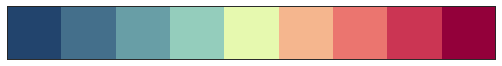

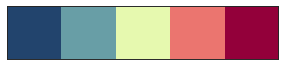

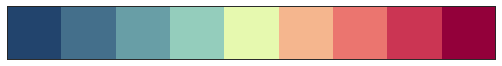

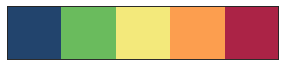

In [6]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Define some helper functions

In [7]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight')
        


In [8]:
## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if SHOW_PLOTS:
        cols = ceil(len(features) / rows)
        fig = plt.figure(figsize=(4*cols,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, cols)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

In [9]:
def getIQR(df, colname) :
    q25 = df[colname].quantile(.25)
    q75 = df[colname].quantile(.75)
    iqr = (q75 - q25)

    upper_lim = q75 + 2 * iqr
    lower_lim = q25 - 2 * iqr

    above_ul = df.loc[df[colname]>upper_lim]
    below_ll = df.loc[df[colname]<lower_lim]
    
    if len(above_ul) > 0 :
        print(str(len(above_ul)) + " or " + str(round((100*len(above_ul)/len(df)),4)) + "% of rows are above the UL ["+ colname + "].")
    if len(below_ll) > 0 :
        print(str(len(below_ll)) + " or " + str(round((100*len(below_ll)/len(df)),4)) + "% of rows are below the LL ["+ colname + "].")

    
    return upper_lim, lower_lim, len(above_ul), len(below_ll)




In [10]:
df = pd.read_csv('../../source/H2.csv')

## Remove last row
#df.drop(df.tail(1).index,inplace=True)
#df['Custid'] = df['Custid'].astype(int)
#df.set_index('Custid', inplace=True)

df_original = df.copy(deep=True)

df.head(3)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30


## Data Preprocessing

### Convert types

In [11]:
MONTHS = ['January', 'February', 'March', 'April', 'May','June',
          'July','August','September','October','November','December']

MONTH_NUMS = [i+1 for i in range(12)]

df['ArrivalDateMonthNumber'] = df['ArrivalDateMonth'].replace(to_replace=MONTHS, value=MONTH_NUMS)
df.loc[:,['ArrivalDateMonth','ArrivalDateMonthNumber']]

,ArrivalDateMonth,ArrivalDateMonthNumber
0,July,7
1,July,7
2,July,7
3,July,7
4,July,7
...,...,...
79325,August,8
79326,August,8
79327,August,8
79328,August,8


In [12]:
df['ArrivalDate'] = df['ArrivalDateYear'].astype(str) + '-' + df['ArrivalDateMonthNumber'].astype(str) + '-' + df['ArrivalDateDayOfMonth'].astype(str)
df['ArrivalDate'] = pd.to_datetime(df['ArrivalDate'])
# df['ArrivalDate']

In [13]:
df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'])
# print(df.dtypes)


### Check nulls

In [14]:
df['Company'] = df['Company'].replace('       NULL', np.nan)

In [15]:
df['Company'][0]

nan

In [16]:
df.isna().sum()

IsCanceled                         0
LeadTime                           0
ArrivalDateYear                    0
ArrivalDateMonth                   0
ArrivalDateWeekNumber              0
ArrivalDateDayOfMonth              0
StaysInWeekendNights               0
StaysInWeekNights                  0
Adults                             0
Children                           4
Babies                             0
Meal                               0
Country                           24
MarketSegment                      0
DistributionChannel                0
IsRepeatedGuest                    0
PreviousCancellations              0
PreviousBookingsNotCanceled        0
ReservedRoomType                   0
AssignedRoomType                   0
BookingChanges                     0
DepositType                        0
Agent                              0
Company                        75641
DaysInWaitingList                  0
CustomerType                       0
ADR                                0
R

Drop Company because too many nulls

In [17]:
df.drop(columns=['Company'],inplace=True)

Impute missing values for Country and Children with modes

In [18]:
df['Country'].fillna(value=df['Country'].mode()[0], inplace=True)

In [19]:
df['Children'].fillna(value=df['Children'].mode()[0], inplace=True)

In [20]:
#df.isna().sum()

### Check duplicates

In [21]:
## duplicates kept
df_hasdups = df.copy()

## duplicated rows
df_dups = df[df.duplicated(keep=False)]

## duplicates removed
df.drop_duplicates(keep='first', inplace=True)

### Separate numeric and non-numeric features

In [22]:
num_feats = df.select_dtypes(include=[np.number]).columns.tolist()
num_feats.remove('IsRepeatedGuest')
num_feats.remove('IsCanceled')

num_feats

['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ArrivalDateMonthNumber']

In [23]:
cat_feats = df.columns.drop(num_feats).to_list()
cat_feats.append('IsRepeatedGuest')
cat_feats.remove('IsCanceled')

cat_feats

['ArrivalDateMonth',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'IsRepeatedGuest',
 'ReservedRoomType',
 'AssignedRoomType',
 'DepositType',
 'Agent',
 'CustomerType',
 'ReservationStatus',
 'ReservationStatusDate',
 'ArrivalDate',
 'IsRepeatedGuest']

### Check Outliers

### Check strange values

In [24]:
## Fix Country Code 'CN' as CHN
df.loc[df['Country']=='CN',['Country']] = 'CHN'
df.loc[df['Country']=='CN',['Country']]


,Country


## Time Series Analysis

In [25]:
df.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'DaysInWaitingList',
       'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'ArrivalDateMonthNumber', 'ArrivalDate'],
      dtype='object')

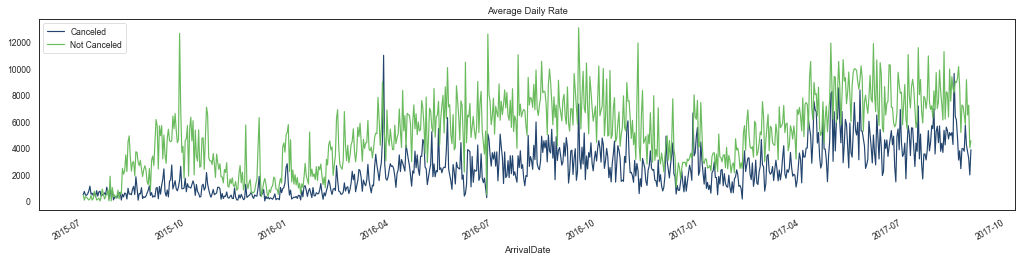

In [26]:
fig, ax = plt.subplots(figsize=(18,4))

df_ts = df.copy()

df_ts['ADR_Diff'] = df_ts['ADR']
df_ts.loc[df_ts['IsCanceled']==True, ['ADR_Diff']] *= 1


#df_ts_diff = df_ts.groupby(['ArrivalDate'])\
#    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[-1], label='Difference')

df_ts.loc[df['IsCanceled']==True,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[0], label='Canceled')

df_ts.loc[df['IsCanceled']==False,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[1], label='Not Canceled')


## Plot percent canceled

plt.title("Average Daily Rate")

plt.legend()
plt.show()

In [27]:
df_ts.loc[df_ts['ArrivalDate']=='2016-04-01',['ArrivalDate','ADR','ADR_Diff','IsCanceled']].groupby(['IsCanceled']).sum()

,ADR,ADR_Diff
IsCanceled,,
0,4587.76,4587.76
1,2604.71,2604.71


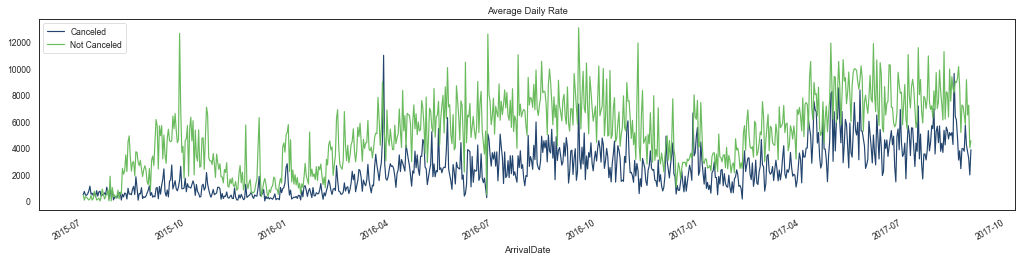

In [28]:
fig, ax = plt.subplots(figsize=(18,4))

df_ts = df.copy()

df_ts['ADR_Diff'] = df_ts['ADR']
df_ts.loc[df_ts['IsCanceled']==True, ['ADR_Diff']] *= 1


#df_ts_diff = df_ts.groupby(['ArrivalDate'])\
#    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[-1], label='Difference')

df_ts.loc[df['IsCanceled']==True,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[0], label='Canceled')

df_ts.loc[df['IsCanceled']==False,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[1], label='Not Canceled')


## Plot percent canceled

plt.title("Average Daily Rate")

plt.legend()
plt.show()

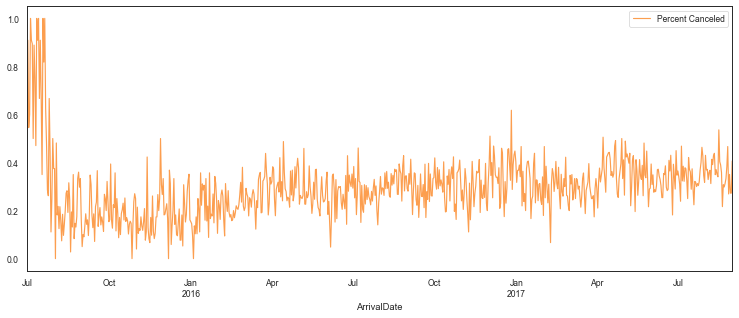

In [29]:
df_ts2 = df.groupby(['ArrivalDate','IsCanceled']).size().unstack()
df_ts2 = df_ts2.T.reset_index(drop=True).T.replace(np.nan,0)
df_ts2['total'] = df_ts2[0]+df_ts2[1]
df_ts2['diff'] = df_ts2[0]-df_ts2[1]

df_ts2['percentCanceled'] = df_ts2[1]/df_ts2['total']

fig, ax = plt.subplots(figsize=(13,5))

df_ts2['percentCanceled'].plot(ax=ax, color=CAT_COLORS[3], label='Percent Canceled')

plt.legend()
plt.show()

In [30]:
import statsmodels.api as sm


In [31]:
endog = df_ts2['percentCanceled']
endog.index = pd.period_range('2015-07-01','2017-08-31',freq='D')

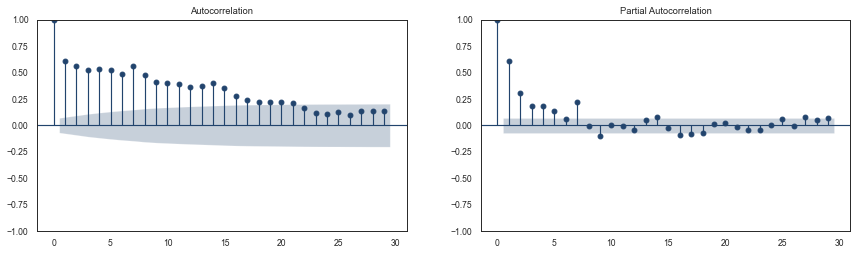

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

sm.graphics.tsa.plot_acf(endog, ax=axes[0])
sm.graphics.tsa.plot_pacf(endog, method="ywm", ax=axes[1])

plt.show()

In [33]:
## Construct SARIMAX Model

## Remove L6 as not significant
# mod = sm.tsa.SARIMAX(endog, order=([1, 2, 3, 4, 5, 6, 7], 0, 0), trend='c')

# Estimate the parameters
# res = mod.fit()

# endog_trim = endog.loc[:'2017-02-15']

## Construct the model on trimmed data
## Remove L6 as not significant
# mod_trim = sm.tsa.SARIMAX(endog_trim, order=([1, 2, 3, 4, 5, 7], 0, 0), trend='ct')

## Estimate the parameters
# res_trim = mod_trim.fit()

In [34]:
## Plots
# fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
## endog[:'2017-03-01'].plot(ax=ax, color=COLORS[1])

# Construct the forecasts

## Don't use these
#fcast = res.get_prediction(start='2017-09-01', end='2018-7-31').summary_frame()
#fcast = res.get_prediction(start='2017-02-16', end='2017-8-30').summary_frame()
#fcast = res_trim.get_prediction(start='2017-02-16', end='2017-8-30').summary_frame()

## Use this
#fcast = res_trim.get_prediction(start='2017-02-16', end='2017-02-28').summary_frame()


#ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
#fcast['mean'].plot(ax=ax, color='r')

#plt.show()

## Feature Engineering

### Add regions for countries

In [35]:
## Data from https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv



In [36]:
## Fix TMP >> TLS
df.loc[df['Country']=='TMP',['Country']] = 'TLS'

In [37]:
country_info = pd.read_csv('../data_in/country_info.csv')
country_info.head(3)


,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN


In [38]:
# country_info.isna().sum()
# Drop nan region: Antarctica is not in dataset

In [39]:
country_info = country_info.loc[~country_info['region'].isna(),:]

In [40]:
df = pd.merge(df,country_info[['alpha-3','region','sub-region']],
              left_on='Country', right_on='alpha-3',
              how='left').drop(columns=['alpha-3'])

In [41]:
cat_feats.append('region')
cat_feats.append('sub-region')

In [42]:
df.loc[df['Country']=='ATA',['region']] = 'Antarctica'
df.loc[df['Country']=='ATA',['sub-region']] = 'Antarctica'

In [43]:
df.isna().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
Agent                          0
DaysInWaitingList              0
CustomerType                   0
ADR                            0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
ReservationStatusDate          0
ArrivalDat

### Add Season column

In [44]:
## From https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime

def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'


In [45]:
df['Season'] = df['ArrivalDate'].map(season_of_date)

In [46]:
df.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'DaysInWaitingList',
       'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'ArrivalDateMonthNumber', 'ArrivalDate', 'region', 'sub-region',
       'Season'],
      dtype='object')

In [47]:
cat_feats.append('Season')

In [48]:
df.loc[df['region'].isna(),['Country']]

,Country


### Percent cancellation lagged

In [49]:
df_pc = df[['IsCanceled']]
df_pc

,IsCanceled
0,0
1,1
2,1
3,1
4,1
...,...
53421,0
53422,0
53423,0
53424,0


In [50]:
df_pc = df.groupby(['ArrivalDate','IsCanceled']).size().unstack()
df_pc = df_pc.T.reset_index(drop=True).T.replace(np.nan,0)
df_pc['Total'] = df_pc[0]+df_pc[1]
df_pc['PctCanceledPrevWeek'] = df_pc[1]/df_pc['Total']

df_pc["ArrivalDate"] = df_pc.index + timedelta(days=7)
df_pc["PrevWeek"] = df_pc.index
df_pc.reset_index(drop=True, inplace=True)
df_pc.drop(columns=[0,1,'Total','PrevWeek'], inplace=True)
df_pc.head(3)

,PctCanceledPrevWeek,ArrivalDate
0,0.500000,2015-07-08
1,0.909091,2015-07-09
2,0.545455,2015-07-10


In [51]:
df = df.join(df_pc.set_index('ArrivalDate'), how='left', on='ArrivalDate')

In [52]:
df.head(20)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDateMonthNumber,ArrivalDate,region,sub-region,Season,PctCanceledPrevWeek
0,0,6,2015,July,27,1,0,2,1,0.0,...,0,0,Check-Out,2015-07-03,7,2015-07-01,Europe,Southern Europe,summer,NaN
1,1,88,2015,July,27,1,0,4,2,0.0,...,0,1,Canceled,2015-07-01,7,2015-07-01,Europe,Southern Europe,summer,NaN
2,1,65,2015,July,27,1,0,4,1,0.0,...,0,1,Canceled,2015-04-30,7,2015-07-01,Europe,Southern Europe,summer,NaN
3,1,92,2015,July,27,1,2,4,2,0.0,...,0,2,Canceled,2015-06-23,7,2015-07-01,Europe,Southern Europe,summer,NaN
4,1,100,2015,July,27,2,0,2,2,0.0,...,0,1,Canceled,2015-04-02,7,2015-07-02,Europe,Southern Europe,summer,NaN
5,1,79,2015,July,27,2,0,3,2,0.0,...,0,1,Canceled,2015-06-25,7,2015-07-02,Europe,Southern Europe,summer,NaN
6,0,3,2015,July,27,2,0,3,1,0.0,...,0,0,Check-Out,2015-07-05,7,2015-07-02,Europe,Southern Europe,summer,NaN
7,1,63,2015,July,27,2,1,3,1,0.0,...,0,0,Canceled,2015-06-25,7,2015-07-02,Europe,Southern Europe,summer,NaN
8,1,62,2015,July,27,2,2,3,2,0.0,...,0,1,No-Show,2015-07-02,7,2015-07-02,Europe,Southern Europe,summer,NaN
9,0,43,2015,July,27,3,0,2,2,0.0,...,0,0,Check-Out,2015-07-05,7,2015-07-03,Europe,Southern Europe,summer,NaN


In [53]:
df['PctCanceledPrevWeek'].fillna(method='bfill', inplace=True)

In [54]:
df.isna().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
Agent                          0
DaysInWaitingList              0
CustomerType                   0
ADR                            0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
ReservationStatusDate          0
ArrivalDat

## Inspect variables: Check histograms

In [55]:
#plot_histograms_boxplots(df, num_feats, rows=3)

In [56]:
#plot_histograms_boxplots(df_hasdups, num_feats, rows=3, title="Histograms with Duplicates Preserved")

In [57]:
## Function to plot histograms of numeric features for specified dataframe, divided by target variable
def plot_histograms_boxplots_target(df, features, target, rows=4, title = "Histograms of Numeric Variables with Target"):
    if show_plots:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows))
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1,1]})
        
            df.pivot(columns=target)[feat].plot(kind = 'hist', stacked=True, ax=axs[0], color=CAT_COLORS[0:2])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1)
        
            sns.boxplot(x=df.loc[df[target]==0,feat], ax=axs[1], color=CAT_COLORS[0], fliersize=2)
            axs[1].set_xlabel(None)
        
            sns.boxplot(x=df.loc[df[target]==1,feat], ax=axs[2], color=CAT_COLORS[1], fliersize=2)
            axs[2].set_xlabel(None)
        
            subf.suptitle(None)

        plt.suptitle(title)
        plt.show()
        if SAVE_PLOTS:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

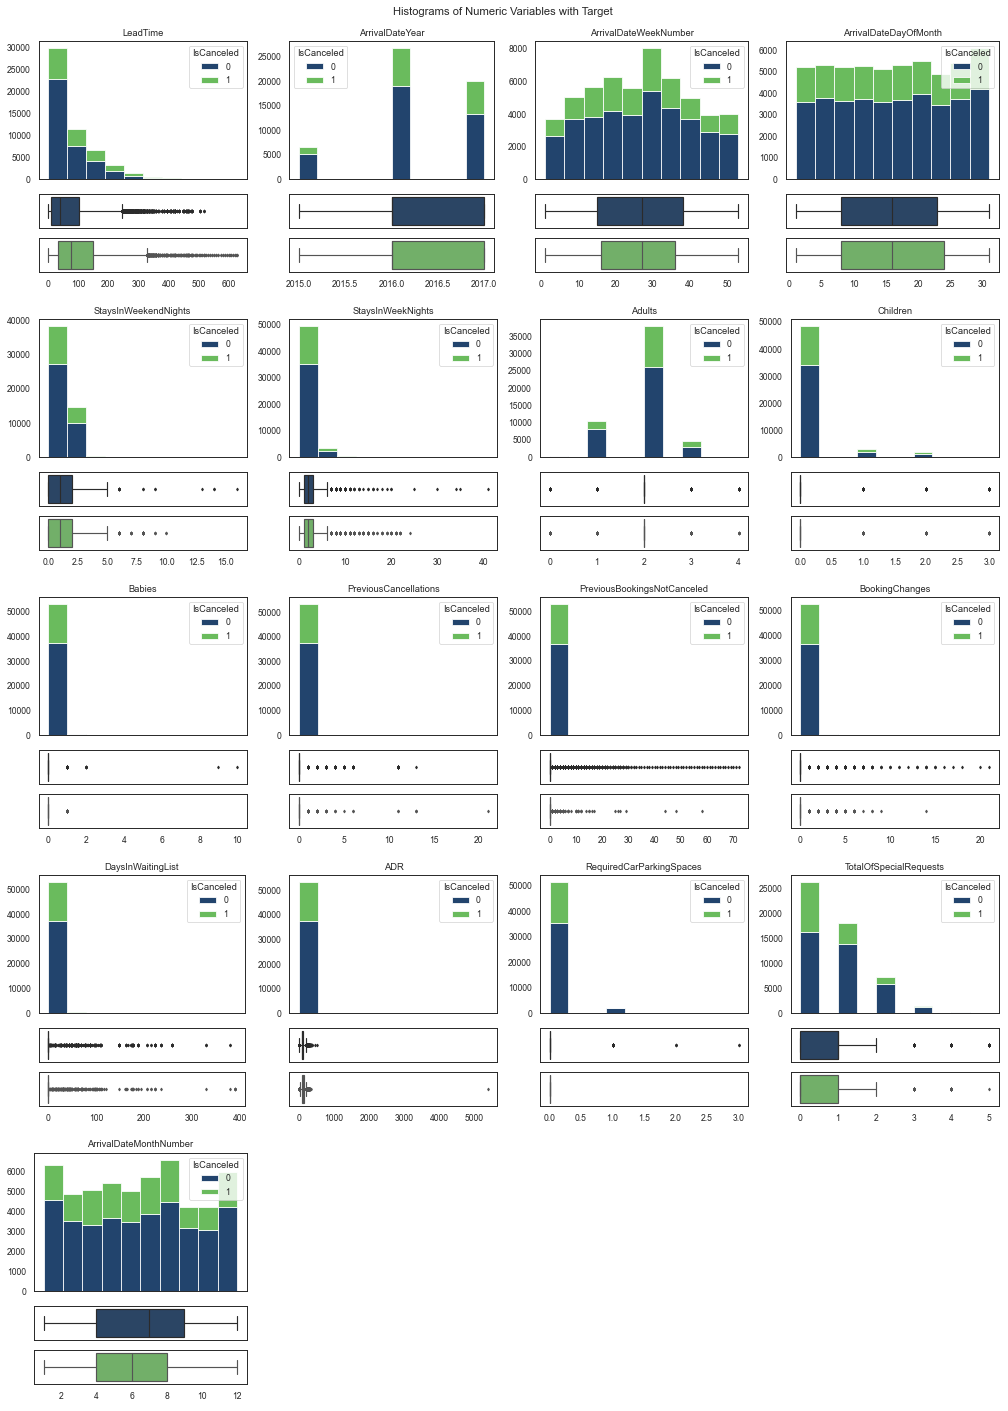

In [58]:
plot_histograms_boxplots_target(df, num_feats, 'IsCanceled', rows=5)

In [59]:
#plot_histograms_boxplots_target(df_hasdups, num_feats, 'IsCanceled', rows=5)

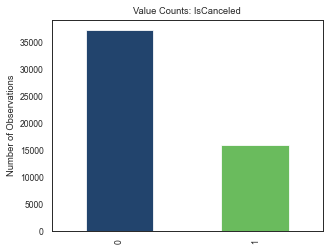

In [60]:
fig, ax = plt.subplots(figsize=(5,4))
df.groupby(['IsCanceled']).size()\
        .plot(kind="bar", stacked=False, color=CAT_COLORS[0:2])
ax.set_xlabel(None)
ax.set_ylabel('Number of Observations')
ax.set_title('Value Counts: IsCanceled')
plt.show()

In [61]:
## Function to plot histograms of cat features for specified dataframe
def plot_cat_counts(df, features, target, rows=6, title = "Count Distributions of Categorical Variables"):
    if show_plots:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows), wspace=0.07, hspace=0.1)
        c = CAT_COLORS[0:2]
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(1, 2, sharey=True) #, gridspec_kw={'width_ratios': [4, 1,1]})
 
            df1 = df.groupby([feat,target]).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=axs[0], color=c)

            df2 = df.groupby([feat,target]).size().unstack(1)
            df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=axs[1], color=c)
            
            subf.suptitle(feat)
            

        plt.suptitle(title)
        plt.show()
        if SAVE_PLOTS:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

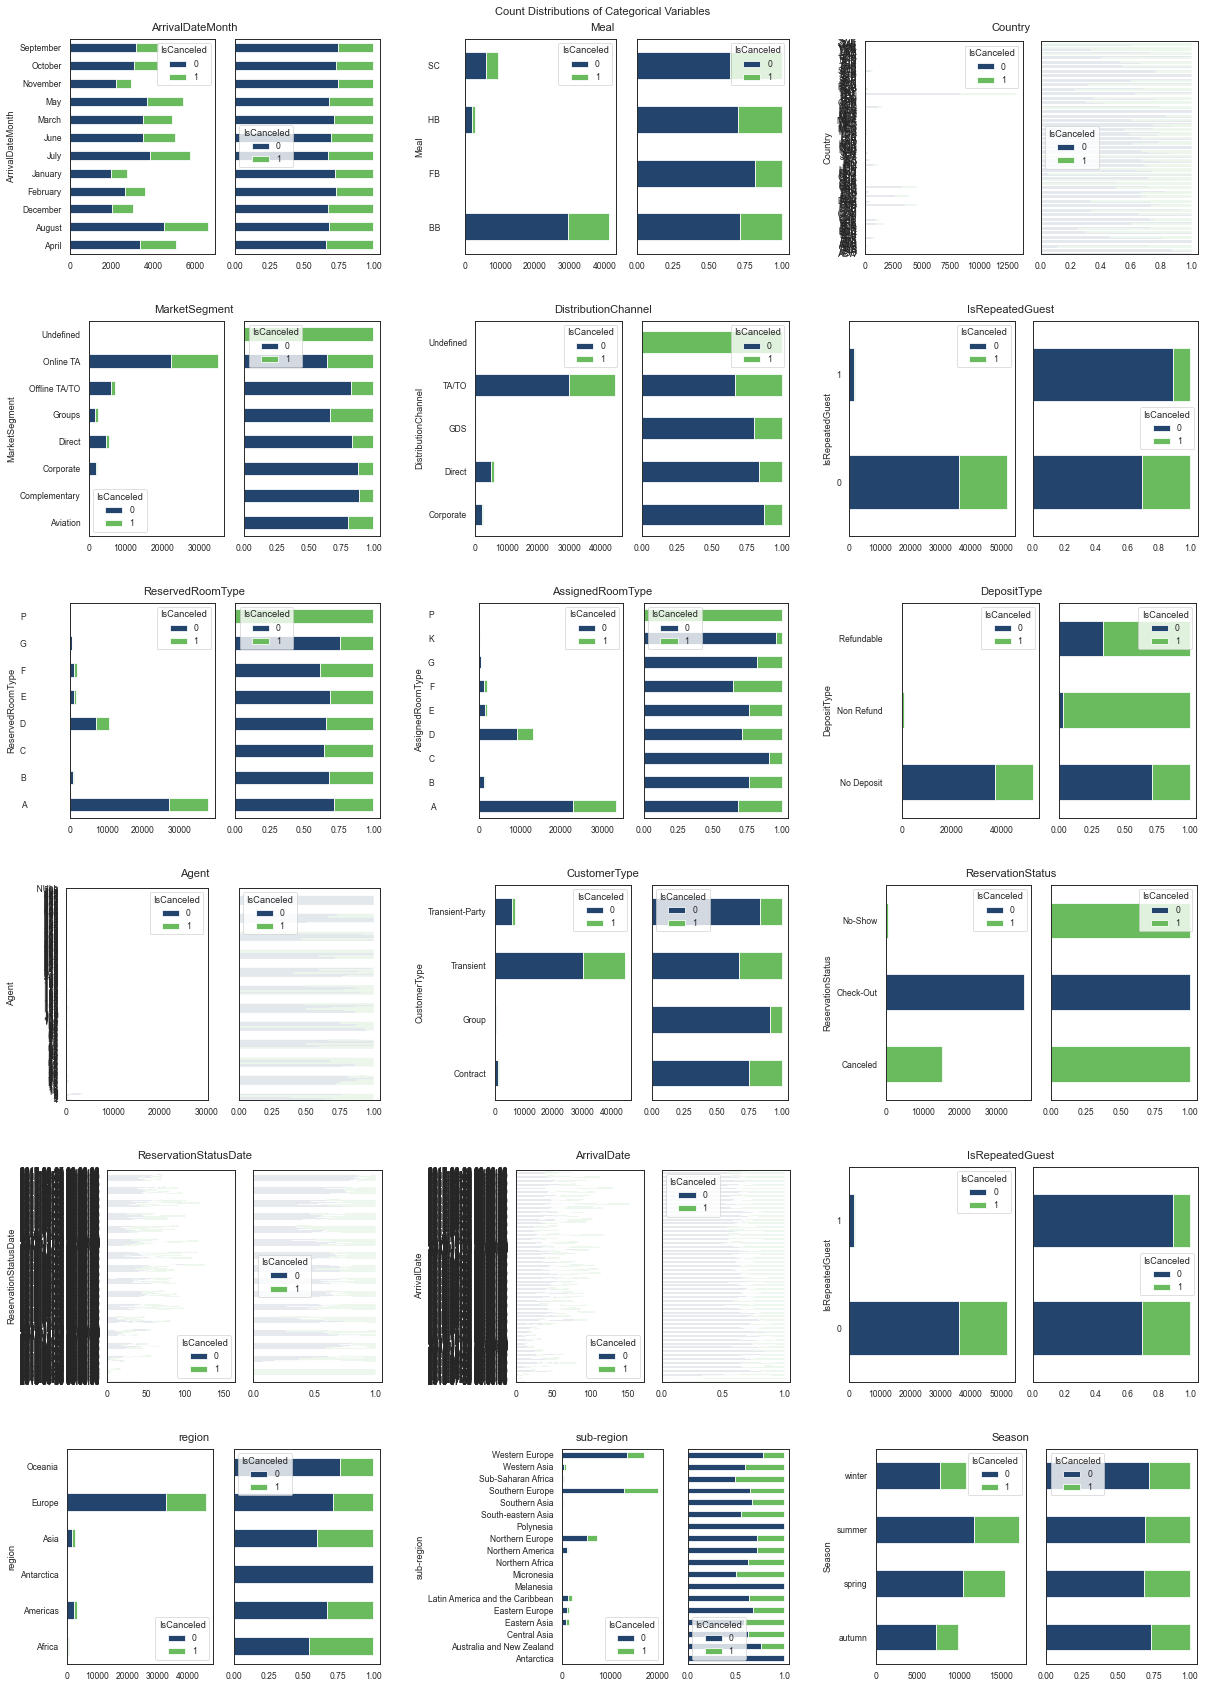

In [62]:
plot_cat_counts(df, cat_feats, 'IsCanceled', rows = 6)

In [63]:
# plot_cat_counts(df_hasdups, cat_feats, 'IsCanceled', rows = 6)

In [64]:
# aggregated and shape data

def show_barplot_compare(df, g1, g2) :
    if show_plots:
        
        df = df.sort_values(by=g2,ascending=False)
    
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(23,23))
 
        df1 = df.groupby([g1,g2]).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=ax[0], color=CONTRAST_COLORS)

        # aggregated and shape data
        df2 = df.groupby([g1,g2]).size().unstack(1)
        df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=ax[1], color=CONTRAST_COLORS)
    
        plt.show()
        if SAVE_PLOTS:
            save_fig('Bar plot '+ g1 + ' ' + g2, fig)
            

In [65]:
def absolute_relative_histoplot(df, feat, target, title='Absolute and Relative Distributions of Canceled Status by Country', figsize=(21,28)):
    df_ar = df.groupby([feat,target]).size().unstack()
    df_ar = df_ar.T.reset_index(drop=True).T.replace(np.nan,0)
    df_ar['total'] = df_ar[0]+df_ar[1]
    df_ar.sort_values(by='total', inplace=True)


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
    df_ar[target] = df_ar[1]
    not_t = 'Not ' + target
    df_ar[not_t] = df_ar[0]

    df_ar.loc[:,[not_t, target]]\
                     .plot(kind="barh", width=1, stacked=True, ax=ax[1], color=CAT_COLORS)
    ax[1].legend(bbox_to_anchor=(.6,1,.4,1), loc="lower left", frameon=False,
                            mode='expand', borderaxespad=0, ncol=2)
    ax[1].set_title('Absolute Distribution', loc='left', fontsize=18)


    df_cc2 = df_ar.loc[:,[not_t, target]].div(df_ar['total'], axis=0)\
                    .plot(kind="barh", width=1, stacked=True, ax=ax[0], color=CAT_COLORS)
    ax[0].legend(bbox_to_anchor=(.6,1,.4,1), loc="lower left", frameon=False,
                            mode='expand', borderaxespad=0, ncol=2)
    ax[0].set_title('Relative Distribution', loc='left', fontsize=18)

    
    ax[0].yaxis.set_label_position("right")
    ax[0].yaxis.tick_right()
    ax[0].set_ylabel(None)
    ax[1].set_ylabel(None)

    
    fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()
    

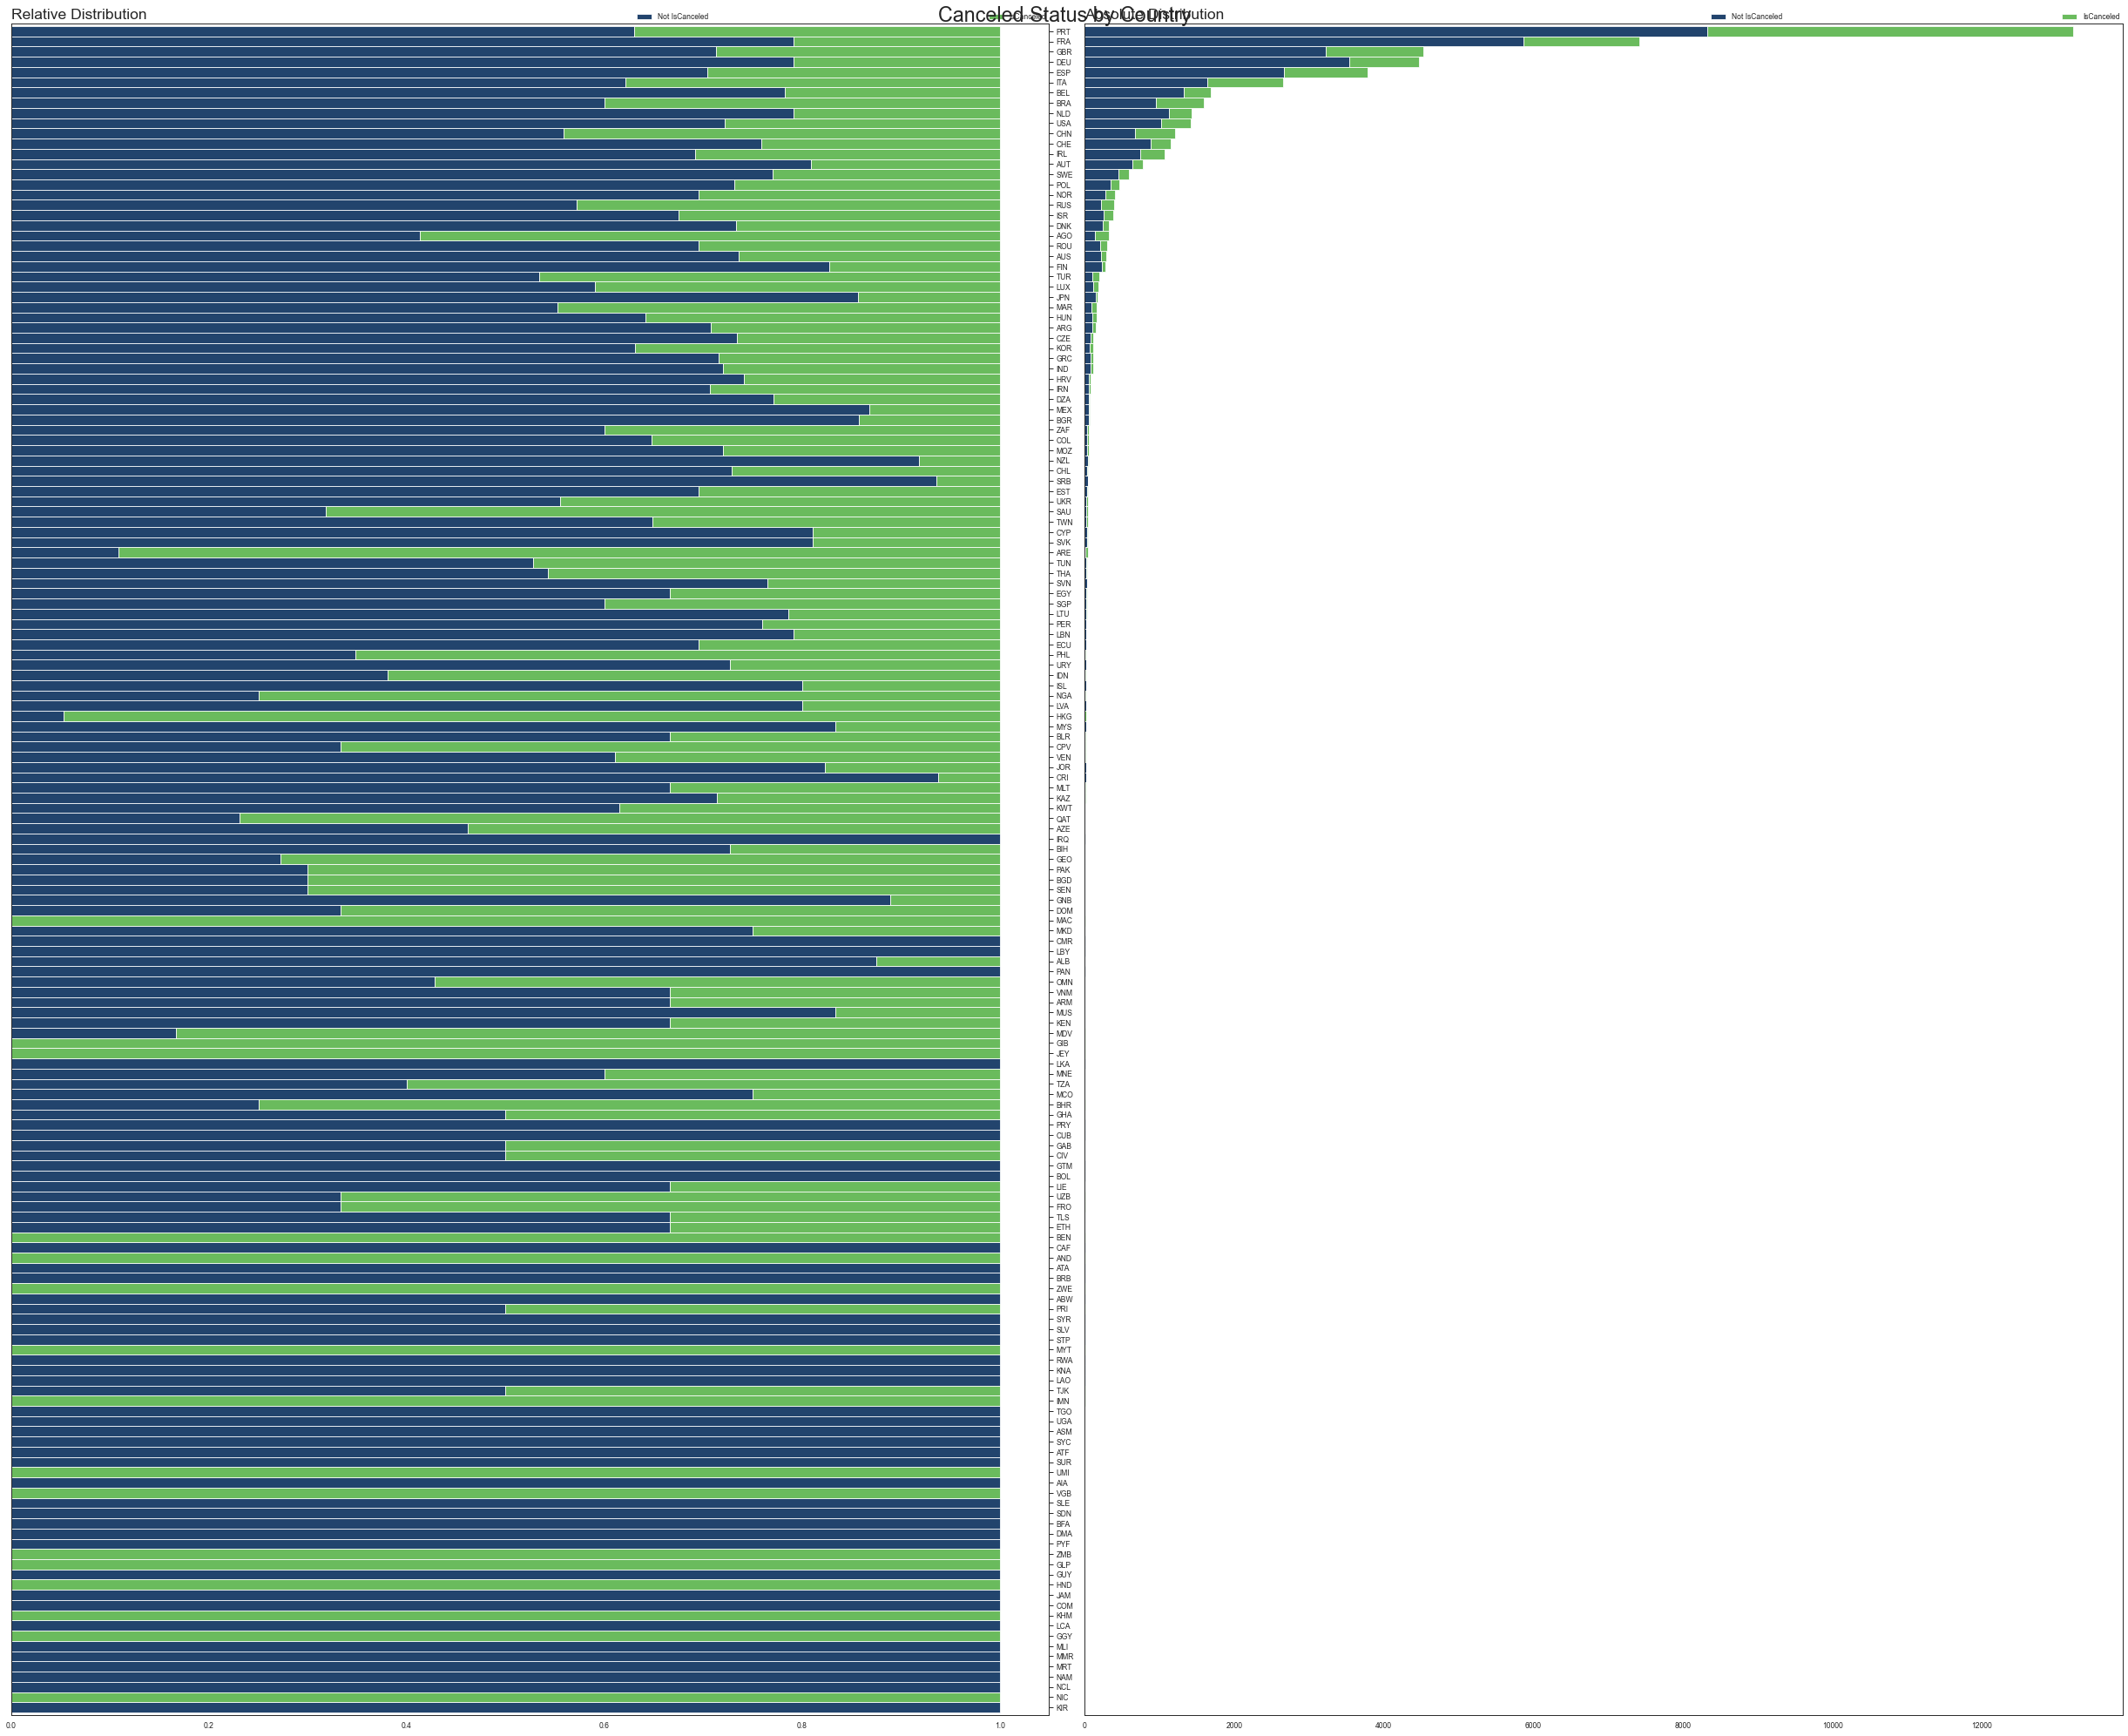

In [66]:
absolute_relative_histoplot(df, 'Country', 'IsCanceled', title='Canceled Status by Country', figsize=(35,29))


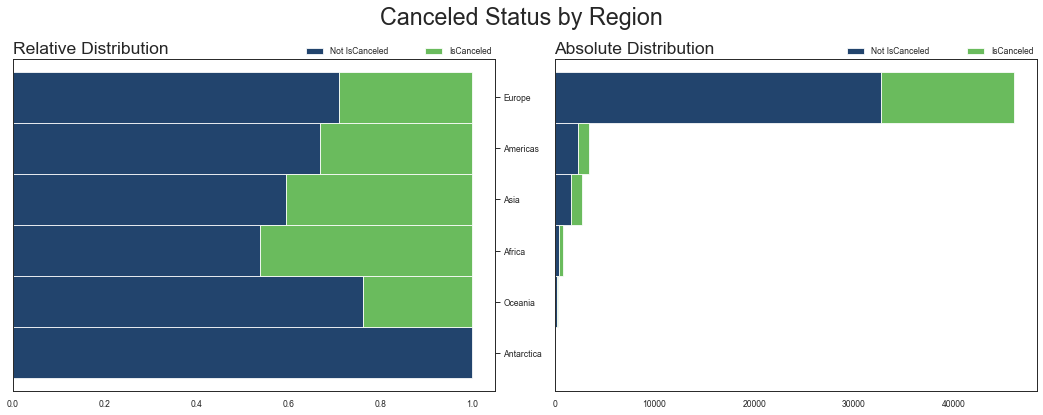

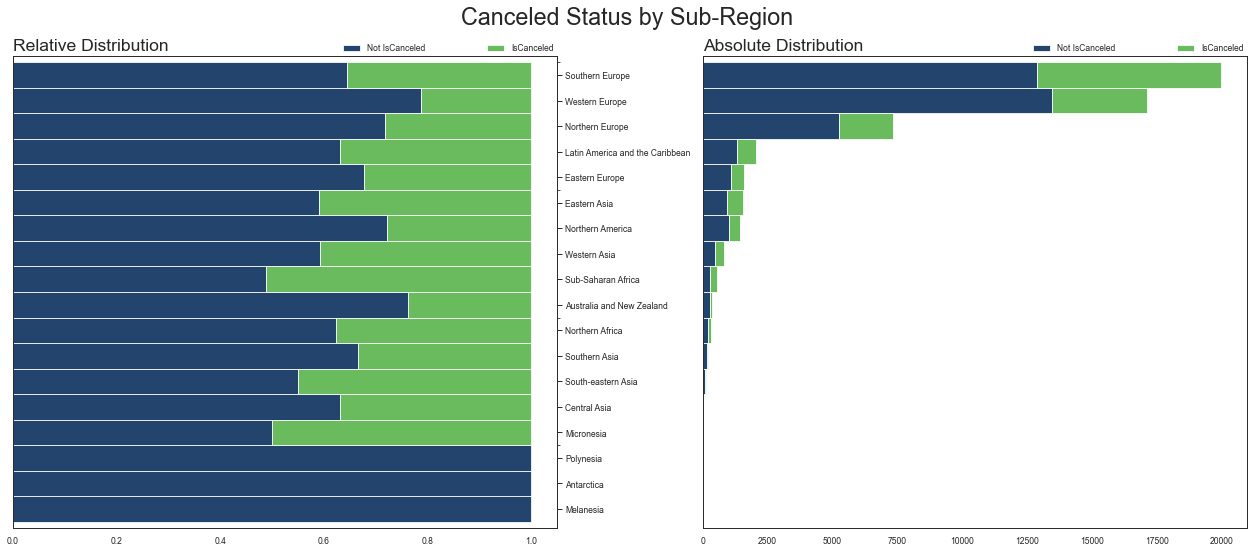

In [67]:
absolute_relative_histoplot(df, 'region', 'IsCanceled', title='Canceled Status by Region', figsize=(15,6))
absolute_relative_histoplot(df, 'sub-region', 'IsCanceled', title='Canceled Status by Sub-Region', figsize=(18,8))


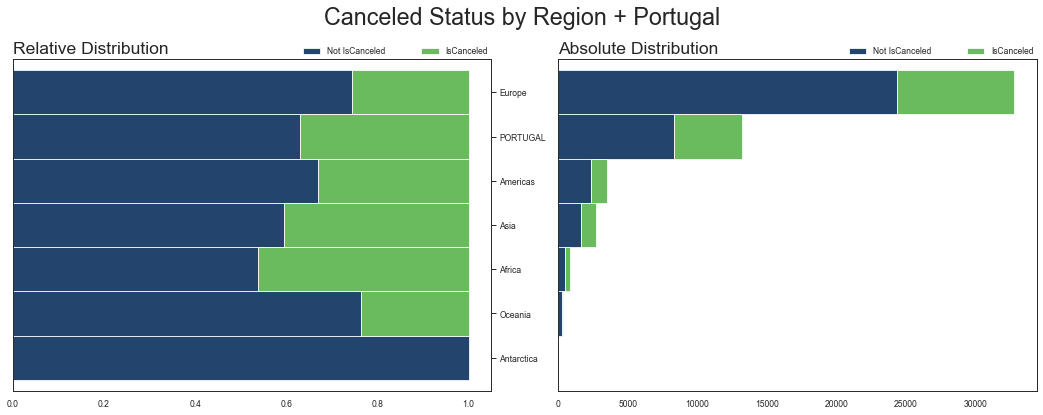

In [68]:
df['region alt'] = df['region']
df.loc[df['Country']=='PRT',['region alt']] = 'PORTUGAL'
absolute_relative_histoplot(df, 'region alt', 'IsCanceled', title='Canceled Status by Region + Portugal', figsize=(15,6))


## Feature Selection

In [69]:
X = df.drop('IsCanceled', axis=1).copy()
y = df.IsCanceled.copy()

In [70]:
#scaler = MinMaxScaler()

In [71]:
#df_scaled = pd.DataFrame(scaler.fit_transform(df[num_feats]), columns=num_feats).join(df[cat_feats])

#df_scaled.head()

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3,
                                                  random_state = 9, stratify = y, shuffle = True)

#### Spearman Correlation

<Figure size 700x560 with 0 Axes>

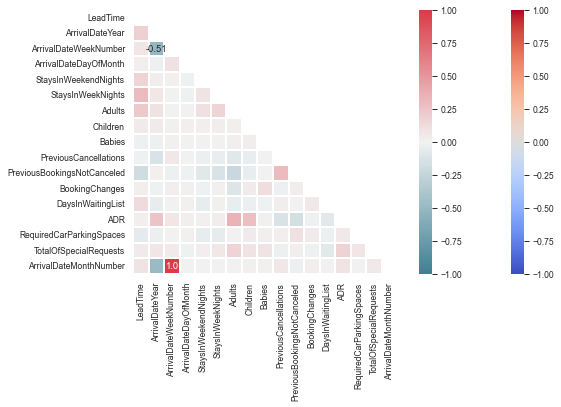

In [73]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[num_feats].corr(method="spearman"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

mask = np.zeros_like(df[num_feats].corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 5))
    ax = sns.heatmap(df[num_feats].corr(), vmin=-1, vmax=1, mask=mask, square=True, linewidths=.2, cmap="coolwarm")

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, mask=mask, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

#### RFE

In [74]:
model = LogisticRegression()

In [75]:
rfecv = RFECV(
    estimator=model,
    scoring="r2",
    n_jobs=-1,
    cv=10
)

_ = rfecv.fit(X_train[num_feats], y_train)
rfe_keep = X_train[num_feats].columns[rfecv.support_]
rfe_keep

Index(['LeadTime', 'ArrivalDateWeekNumber', 'StaysInWeekendNights',
       'StaysInWeekNights', 'Adults', 'Children', 'Babies',
       'PreviousCancellations', 'PreviousBookingsNotCanceled',
       'BookingChanges', 'DaysInWaitingList', 'ADR',
       'RequiredCarParkingSpaces', 'TotalOfSpecialRequests',
       'ArrivalDateMonthNumber'],
      dtype='object')

#### Lasso Regression

In [76]:
reg = LassoCV()
reg.fit(X_train[num_feats], y_train)
coef = pd.Series(reg.coef_, index = X_train[num_feats].columns)
coef

LeadTime                       0.001074
ArrivalDateYear                0.000000
ArrivalDateWeekNumber         -0.000772
ArrivalDateDayOfMonth          0.000000
StaysInWeekendNights           0.002867
StaysInWeekNights              0.020501
Adults                         0.000000
Children                       0.000000
Babies                        -0.000000
PreviousCancellations          0.023331
PreviousBookingsNotCanceled   -0.002107
BookingChanges                -0.051790
DaysInWaitingList             -0.001119
ADR                            0.001342
RequiredCarParkingSpaces      -0.041516
TotalOfSpecialRequests        -0.092498
ArrivalDateMonthNumber        -0.000000
dtype: float64

In [77]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 11 variables and eliminated the other 6 variables


In [78]:
coef.sort_values()

TotalOfSpecialRequests        -0.092498
BookingChanges                -0.051790
RequiredCarParkingSpaces      -0.041516
PreviousBookingsNotCanceled   -0.002107
DaysInWaitingList             -0.001119
ArrivalDateWeekNumber         -0.000772
Babies                        -0.000000
ArrivalDateMonthNumber        -0.000000
Adults                         0.000000
ArrivalDateDayOfMonth          0.000000
ArrivalDateYear                0.000000
Children                       0.000000
LeadTime                       0.001074
ADR                            0.001342
StaysInWeekendNights           0.002867
StaysInWeekNights              0.020501
PreviousCancellations          0.023331
dtype: float64

In [79]:
lasso_keep = coef[coef != 0.0].index.values

lasso_keep

array(['LeadTime', 'ArrivalDateWeekNumber', 'StaysInWeekendNights',
       'StaysInWeekNights', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'BookingChanges',
       'DaysInWaitingList', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests'], dtype=object)

In [80]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

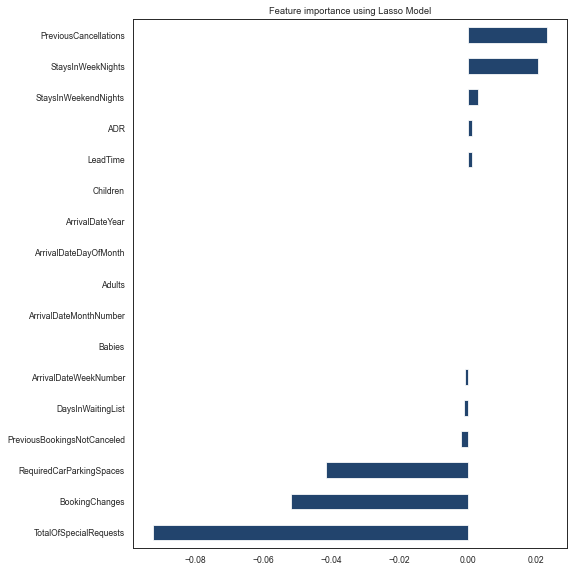

In [81]:
plot_importance(coef,'Lasso')

#### Chi-Squared

In [82]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [83]:
#X_train_cat = X_train[cat_feats]

#for var in X_train_cat:
    #TestIndependence(X_train_cat[var], y_train, var)

In [84]:
num_feats_keep = list(np.unique(np.append(lasso_keep, rfe_keep.values)))

cat_feats_keep = ['Meal', 'MarketSegment', 'DistributionChannel', 
                  'ReservedRoomType', 'AssignedRoomType', 'DepositType',
                  'CustomerType', 'Season', 'region alt']

In [85]:
num_feats_keep.remove('ArrivalDateMonthNumber')

In [86]:
num_feats_keep

['ADR',
 'Adults',
 'ArrivalDateWeekNumber',
 'Babies',
 'BookingChanges',
 'Children',
 'DaysInWaitingList',
 'LeadTime',
 'PreviousBookingsNotCanceled',
 'PreviousCancellations',
 'RequiredCarParkingSpaces',
 'StaysInWeekNights',
 'StaysInWeekendNights',
 'TotalOfSpecialRequests']

In [87]:
keep_feats = num_feats_keep + cat_feats_keep

In [88]:
X_train = X_train[keep_feats].copy()

X_val = X_val[keep_feats].copy()

X = X[keep_feats].copy()

### OHE

In [89]:
#ONE HOT ENCODING

X_train = pd.get_dummies(X_train, columns = cat_feats_keep)
X_val = pd.get_dummies(X_val, columns = cat_feats_keep)
X = pd.get_dummies(X, columns = cat_feats_keep)

## GBC

In [90]:
def avg_score(model, data_to_slice, y_to_slice, columns_to_use):
    # apply kfold
    skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    f1_list = []

    for train_index, test_index in skf.split(data_to_slice[columns_to_use],y_to_slice):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = data_to_slice[columns_to_use].iloc[train_index], data_to_slice[columns_to_use].iloc[test_index]
        y_train, y_val = y_to_slice.iloc[train_index], y.iloc[test_index]
        
        # applies the model 
        model_fit = model.fit(X_train, y_train)
        # predicts training 
        y_pred_train =  model_fit.predict(X_train)
        #predicts validation 
        y_pred_val = model_fit.predict(X_val)
        # prints metric results 
        
        #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
        
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_val,y_val)
        f1_score_val = f1_score(y_val, y_pred_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        f1_list.append(f1_score_val)
        
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_f1 = round(np.mean(f1_list),3)
    std_f1 = round(np.std(f1_list),2)
    return str(avg_train) + '+/-' + str(std_train),\
            str(avg_test) + '+/-' + str(std_test) , str(avg_f1) + '+/-' + str(std_f1), avg_f1

In [92]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [95]:
GB = GradientBoostingClassifier(random_state = 9)

CV=RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=9)

params = {'loss': ('deviance', 'exponential'), 'max_features':('auto', 'sqrt', 'log2'), 'learning_rate':np.arange(0.1,1,0.1), 'n_estimators' : np.arange(100, 300, 50)}

RSCV = RandomizedSearchCV(GB, param_distributions=params, scoring='f1', n_jobs=-1, cv=CV, random_state=9, n_iter=10)

RSCV.fit(X_train, y_train)

print(RSCV.best_params_)
print(RSCV.best_score_)

{'n_estimators': 250, 'max_features': 'log2', 'loss': 'exponential', 'learning_rate': 0.7000000000000001}
0.6505550045946213


In [96]:
GB_model = GradientBoostingClassifier(n_estimators=250, max_features='log2', loss='exponential', learning_rate=0.7, random_state=9)

In [97]:
avg_score(GB_model, X, y, X.columns)

('0.819+/-0.0', '0.808+/-0.0', '0.654+/-0.01', 0.654)

## XGBC

In [ ]:
#https://www.datacamp.com/community/tutorials/xgboost-in-python
#https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

In [ ]:
import xgboost as xgb

In [ ]:
xgbc = xgb.XGBClassifier(objective ='binary:logistic', random_state=9, n_jobs=-1)

In [ ]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

In [ ]:
xgbc.fit(X_train,y_train)

preds = xgbc.predict(X_val)

In [ ]:
f1_score(preds, y_val)

In [ ]:
#data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
#params = {"objective":"binary:logistic"}

#cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    #num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)